In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

# self-consistent sulotion of electron hole

In [2]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 60


vmax = 10 # 速度最大值
nx = 1000
nv = 1000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## Schamel distribution
$$ f_e (v^2>2\phi) = \exp \left[ -\frac{\left(\sqrt{v^2-2\phi}+u\right)^2}{2} \right] $$
$$ f_e (v^2<2\phi) = \exp \left[ -\beta \left(\frac{v^2}{2}-\phi\right) - \frac{u^2}{2} \right] $$
其中$v$为孤波参考系中的速度，静系速度$v_0=v+u$
- 此分布下的自洽孤波，用Newton-Raphson法解出

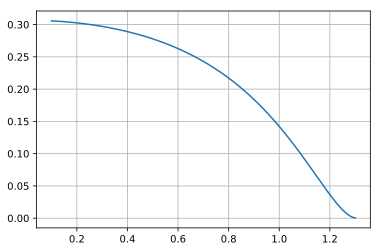

In [3]:
u = np.linspace(0.1,1.3,num=200)
beta = -2

r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
b = np.exp(-u**2/2)*(1-beta-u**2)/np.sqrt(np.pi)
psi = (r1*15/16/b)**2
I = ( (3-u**2)*r1-1.0 )/2.0
psi1 = -3.0*r1/I*1.0

plt.plot(u,psi)
# plt.plot(u,abs(psi1))
plt.grid()
plt.show()

In [4]:
u = 1.2
beta = -2

r1 = 1+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
b = np.exp(-u**2/2)*(1-beta-u**2)/np.sqrt(np.pi)

psi = (r1*15/16/b)**2
# I = ( (3-u**2)*r1-1.0 )/2.0
# psi1 = -3.0*r1/I
delta = 4.0/np.sqrt(r1)

print(delta)
print(psi)
# print(psi1)

13.537634197067431
0.03650027604554218


In [5]:
xp = (x-L/2)/delta
phi = 0.9*psi*np.cosh(xp)**(-4)

In [6]:
@nb.jit
def nonvec_f_fun_sech4(v,phi):
    r = 0
    v_waveframe = v
    w = v_waveframe**2/2-phi
    if v_waveframe<=-abs(2*phi)**0.5:
        r=math.exp(-(-(2*w)**0.5+u)**2/2) 
    elif v_waveframe>abs(2*phi)**0.5:
        r=math.exp(-( (2*w)**0.5+u)**2/2) 
    else:
        r =math.exp(-beta*w-u**2/2) 
    return r/(2*np.pi)**0.5
f_fun_sech4 = np.vectorize(nonvec_f_fun_sech4)

In [8]:
for count in tqdm(range(10)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech4(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    
    # natural BC
#     laplace[0][0]=-1
#     laplace[-1][-1]=-1

    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-5:
        print("Sucess! Iteration counts =", count)
        break
print("err =", err)

 20%|████████████████▌                                                                  | 2/10 [00:01<00:04,  1.81it/s]

Sucess! Iteration counts = 2
err = 5.395624780841654e-10


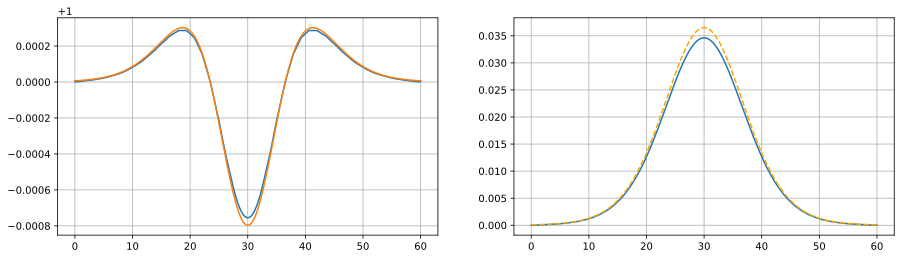

In [9]:
# psi = 0.0235
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot(121)
ax1.plot(x,n_vector)
ax1.plot(x,1.0+psi/delta**2*(16*np.cosh(xp)**(-4)-20*np.cosh(xp)**(-6)))
ax1.grid()
ax3 = plt.subplot(122)
ax3.plot(x,phi)
ax3.plot(x,psi*np.cosh((x-L/2)/delta)**(-4),color='orange',linestyle='--')
ax3.grid()
# ax3.set_xlim(0.3*L,0.7*L)
plt.show()

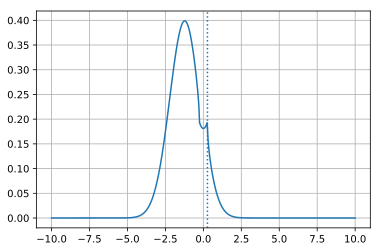

In [10]:
V,Phi=np.meshgrid(v,phi)
f_matrix = f_fun_sech4(V,Phi)
fv = f_matrix.sum(axis=0)*dx/L
plt.plot(v,f_matrix[500,])
plt.axvline(np.sqrt(2*psi),linestyle=':')
# plt.xlim(0.2,0.6)
# plt.ylim(0.3,0.41)
plt.grid()

In [11]:
def phi4_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-4)

def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para4,pcov=curve_fit(phi4_theo,x,phi)
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para4[1]-delta)/para4[1]*100,2)
Dpsi = round(abs(para4[0]-psi)/para4[0]*100,2)  
print('sech4 fit:',para4)
print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')

sech4 fit: [ 0.03462938 13.52295439]
sech2 fit: [0.03509697 9.02359225]
Dpsi     : 5.4 %
Ddelta   : 0.11 %


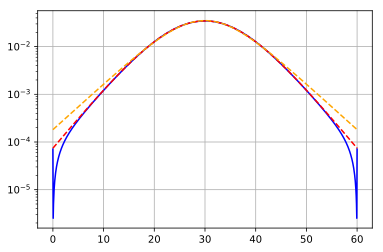

In [926]:
plt.plot(x,phi,color='blue')
plt.plot(x,phi4_theo(x,para4[0],para4[1]),'--',color='red')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),'--',color='orange')
# plt.plot(x,phi2_theo(x,para2[0],para2[1]),color='orange')
# plt.xlim(0.3*L,0.7*L)
plt.yscale('log')
plt.grid()
plt.show()

In [927]:
mat.append([u,round(para4[1],3),round(delta,3),Ddelta,round(para4[0],3),round(psi,3),Dpsi])

In [928]:
table = PrettyTable(['u','delta_sc','delta_th','delta_err(%)','psi_sc','psi_th','psi_err(%)'])
for i in range(len(mat)):
    table.add_row(mat[i])
print('beta=',beta)
print(table)

beta= -2
+-----+----------+----------+--------------+--------+--------+------------+
|  u  | delta_sc | delta_th | delta_err(%) | psi_sc | psi_th | psi_err(%) |
+-----+----------+----------+--------------+--------+--------+------------+
| 0.1 |   5.12   |   4.02   |    21.48     | 0.591  | 0.306  |   48.24    |
| 0.2 |  5.165   |  4.081   |    20.98     | 0.575  | 0.303  |   47.37    |
| 0.3 |  5.244   |  4.187   |    20.16     | 0.549  | 0.297  |    45.9    |
| 0.4 |  5.362   |  4.343   |    19.01     | 0.514  | 0.289  |   43.76    |
| 0.5 |  5.528   |  4.559   |    17.53     |  0.47  | 0.278  |   40.89    |
| 0.6 |  5.755   |   4.85   |    15.73     | 0.418  | 0.263  |   37.18    |
| 0.7 |  6.066   |   5.24   |    13.61     |  0.36  | 0.243  |    32.5    |
| 0.8 |  6.497   |   5.77   |    11.19     | 0.296  | 0.217  |   26.69    |
| 0.9 |  7.119   |  6.514   |     8.49     | 0.229  | 0.184  |   19.64    |
| 1.0 |  8.074   |  7.625   |     5.56     |  0.16  | 0.142  |   11.31    |
| 1

In [929]:
# mat = mat[0:-1]
# mat = []